In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble, subnetwork

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('concrete')

In [3]:
y_mean = torch.mean(y_train)
y_sd = torch.std(y_train)

y_train = (y_train - y_mean) / y_sd

In [4]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [50, 50], learning_rate = 0.001)

initial loss:  1.1259214878082275
final loss:  -1.9873043298721313
initial loss:  1.2560888528823853
final loss:  -1.9728612899780273
initial loss:  1.102752685546875
final loss:  -1.966622233390808
initial loss:  1.1273099184036255
final loss:  -2.141080856323242
initial loss:  1.0813953876495361
final loss:  -1.9889304637908936


Deep ensemble test MAPE:  0.1503488
Deep ensemble test RMSE:  5.6633615
Deep ensemble test NLLK:  4.227841
Deep ensemble test CRPS:  tensor(2.9610)


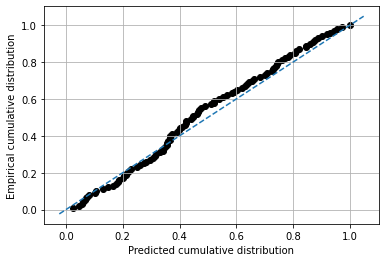

Deep ensemble test calibration error when step size is 0.001:  1.4636923469387766
Deep ensemble test calibration error when step size is 0.01:  0.1477423469387756
Deep ensemble test calibration error when step size is 0.1:  0.014732142857142859


In [5]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [6]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.72it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.80it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.19it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           4.152
  RMSE          5.663
  MDAE          2.898
  MARPD         13.695
  R2            0.886
  Correlation   0.941
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.052
  Mean-absolute Calibration Error       0.048
  Miscalibration Area                   0.049
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.125
     Group Size: 0.56 -- Calibration Error: 0.073
     Group Size: 1.00 -- Calibration Error: 0.048
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.133
     Group Size: 0.56 -- Calibration Error: 0.082
     Group Size: 1.00 -- Calibration Error: 0.052
===============

Lims is None. Setting lims now:
min_max_true: (2.33, 80.2)
min_max_pred: (4.2838135, 77.772446)
lims: (2.33, 80.2)
lims_ext: (-5.456999588012696, 87.98699645996093)


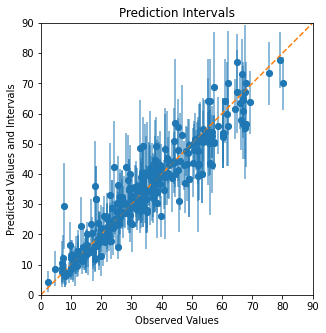

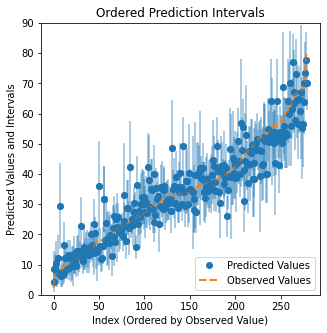

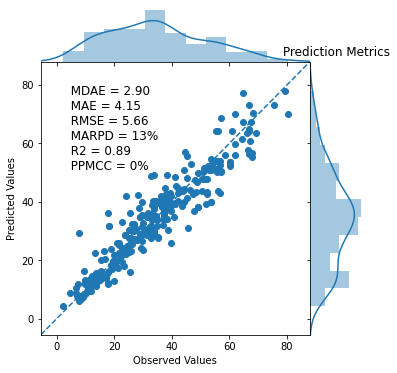

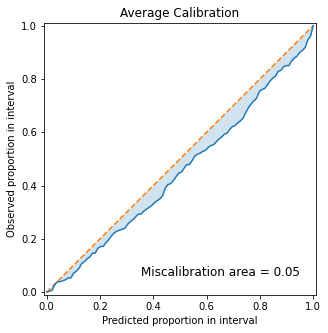

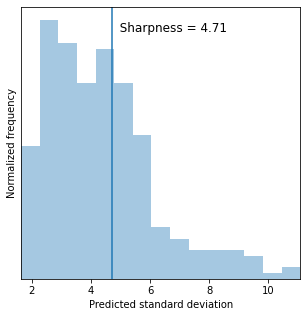

In [7]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [8]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 200, n_features = 100, learning_rate = 0.001)

final loss:  -2.573166847229004


Concrete dropout test MAPE:  0.17969911
Concrete dropout test RMSE:  6.2230935
Concrete dropout test NLLK:  5.6164675
Concrete dropout test CRPS:  tensor(3.3867)


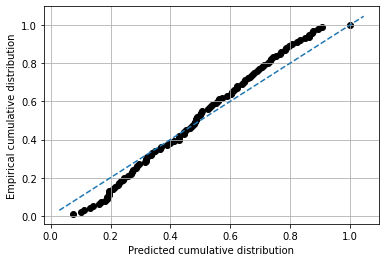

Concrete dropout test calibration error when step size is 0.001:  3.6744979591836744
Concrete dropout test calibration error when step size is 0.01:  0.36525255102040827
Concrete dropout test calibration error when step size is 0.1:  0.03012755102040817


In [9]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy()) * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [10]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.59it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.86it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           4.510
  RMSE          6.223
  MDAE          3.249
  MARPD         17.507
  R2            0.862
  Correlation   0.933
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.117
  Mean-absolute Calibration Error       0.104
  Miscalibration Area                   0.105
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.178
     Group Size: 0.56 -- Calibration Error: 0.136
     Group Size: 1.00 -- Calibration Error: 0.104
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.227
     Group Size: 0.56 -- Calibration Error: 0.149
     Group Size: 1.00 -- Calibration Error: 0.117
===============

Lims is None. Setting lims now:
min_max_true: (2.33, 80.2)
min_max_pred: (-0.11605072, 83.04727)
lims: (-0.11605072, 83.04727)
lims_ext: (-8.432382965087891, 91.36360397338868)


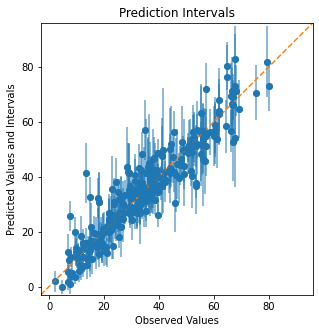

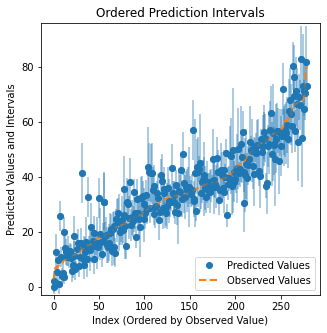

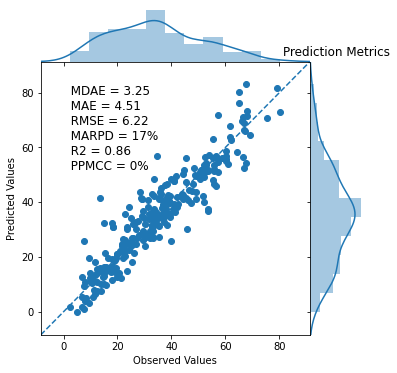

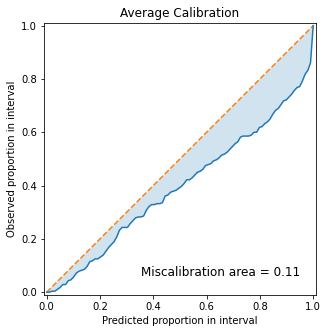

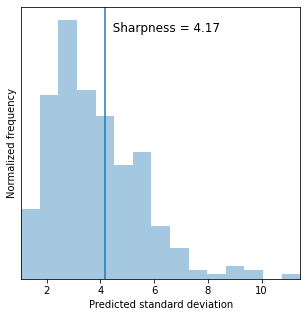

In [11]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [31]:
subnetwork_model = subnetwork.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [50, 50], learning_rate = 0.004)

initial loss:  1.154191493988037
final loss:  -1.0274869203567505


Subnetwork test MAPE:  0.17074464
Subnetwork test RMSE:  6.0335584
Subnetwork test NLLK:  4.5220504
Subnetwork test CRPS:  tensor(3.3063)


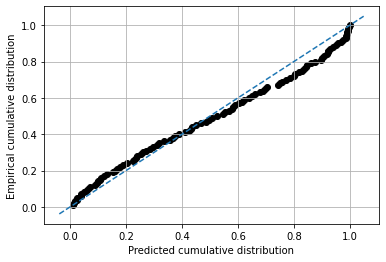

Subnetwork test calibration error when step size is 0.001:  2.069714285714285
Subnetwork test calibration error when step size is 0.01:  0.20800765306122443
Subnetwork test calibration error when step size is 0.1:  0.02063775510204081


In [32]:
mean_pred, var_pred = subnetwork.test_model(subnetwork_model, x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Subnetwork test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Subnetwork test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Subnetwork test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Subnetwork test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Subnetwork test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Subnetwork test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Subnetwork test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [33]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.94it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.81it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           4.554
  RMSE          6.034
  MDAE          3.613
  MARPD         15.288
  R2            0.870
  Correlation   0.933
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.084
  Mean-absolute Calibration Error       0.075
  Miscalibration Area                   0.076
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.152
     Group Size: 0.56 -- Calibration Error: 0.097
     Group Size: 1.00 -- Calibration Error: 0.075
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.160
     Group Size: 0.56 -- Calibration Error: 0.110
     Group Size: 1.00 -- Calibration Error: 0.084
===============

Lims is None. Setting lims now:
min_max_true: (2.33, 80.2)
min_max_pred: (3.0398216, 69.61858)
lims: (2.33, 80.2)
lims_ext: (-5.456999588012696, 87.98699645996093)


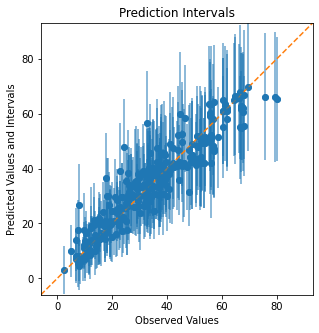

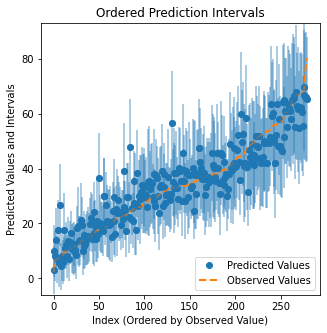

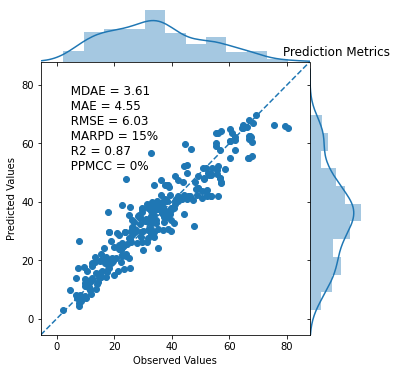

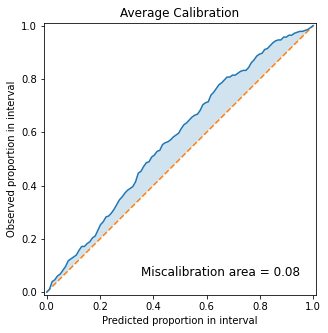

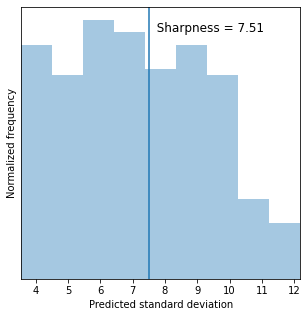

In [34]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))